# Importing Lib and Dependencies Reqioured For PyTorch 3D.
## Open In Google Colab for Better Understand and fast execution.

In [ ]:
'''
Before Going to work with PyTorch 3D Download this resources or library to run 
this code.
when working with PyTorch3D it will show error so we can download via two ways:
1. Via Released wheel
2. Via PyTorch3D Source
'''
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    686      0 --:--:-- --:--:-- --:--:--   682
100  404k    0  404k    0     0   798k      0 --:--:-- --:--:-- --:--:--  798k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-lrd6477r
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-lrd6477r
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 645kB 9.7MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.4.0-cp37-cp37m-linux_x86_64.whl size=18582014 sha256=2bc79f1fb5af6fe7476df822edc1c24a8ce0c6ae4c47383a65fe8ad0b459b21a
  Stored in directory: /tmp/pip-ephem-wheel-cache-hxudhrtv/wheels/89/69/08/d864f516508b5d943259c6088baa150ebd

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from pytorch3d.io import load_obj, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)


# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [ ]:
# here we are going to download a image_grid.py file from official github repo of pytorch3d
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-04-09 05:43:04--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-04-09 05:43:04 (21.1 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



# File Format Required For 3D Meshe And Structure

For Conversion of image into 3d Meshes and texture we have to create file into few formats :
1. create a .obj file of image
2. create a mtl file of image
3. create a texture image in .png format

In [ ]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2021-04-09 05:43:04--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  1.36MB/s    in 0.2s    

2021-04-09 05:43:05 (1.36 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2021-04-09 05:43:05--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

# Setup Cuda
1. when working with PyTorch speed of cpu will decrease So here for execution   we use Cuda (CUDA-enabled graphics processing unit for general purpose processing) or if cuda is not working then use cpu.

# Set file Path and load file
For working with load file we have to set path or give path of .obj via we can load file into meshes.




In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# Structure
With the help of matplotlib showing image structure and texture.
Meshes is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

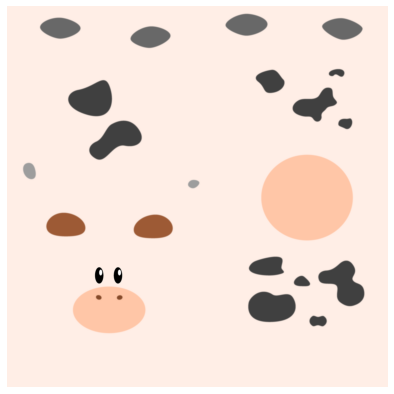

In [ ]:
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis("off");

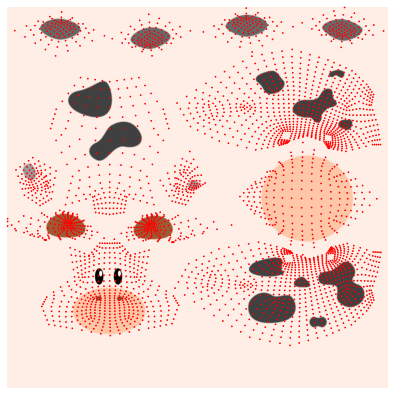

In [ ]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.grid("off");
plt.axis("off");

# Initialize Setting 
Now we initalize the setting of camera :
1. first we create a renderer
2. renderer uses a perspective camera, point light
3. apply phong shading

In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

# Changing Light of camera
Here after setting we can see in the output light is in front of Cow image and Now we can change  the light setting to back side of image. 

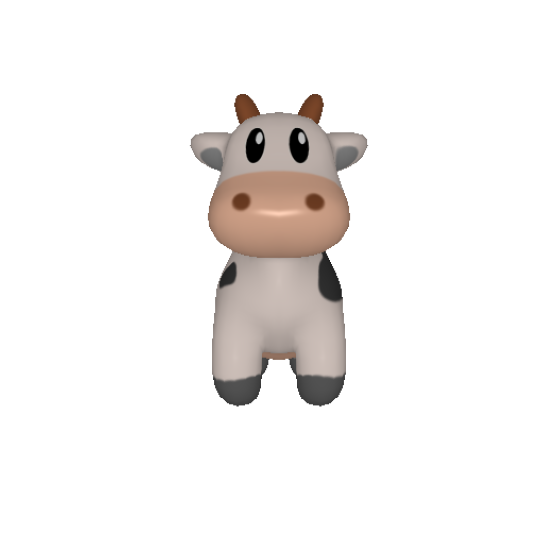

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [ ]:
# Now move the light so it is on the +Z axis which will be behind the cow. 
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

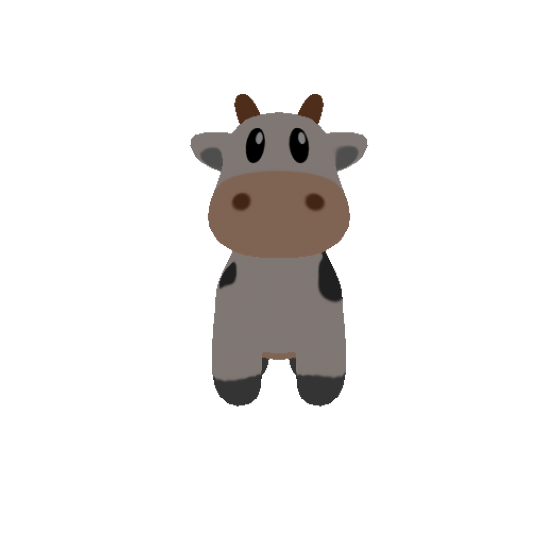

In [ ]:
# Showing light behind the Cow
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

# Camera Setting
Along with Camera setting we can  make few more changes for better understand image:
1. change viewing angle of the camera (Rotate the object)
2. change in position of point light (light properties)
3. change the material reflectance properties of the mesh (Modify material Property)

In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

# Showing Image with help of matplotlib after changes on properties of image. 

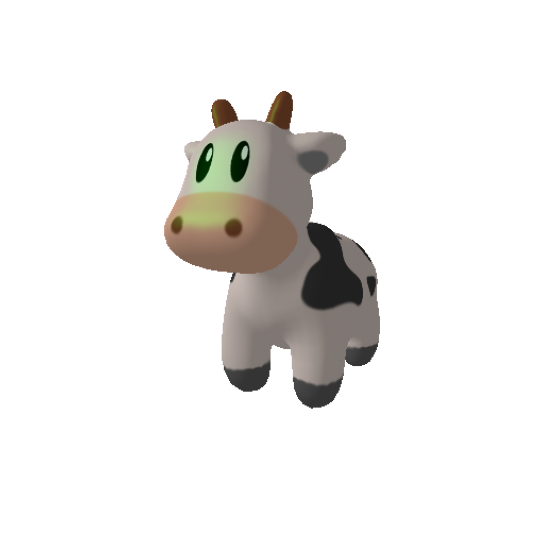

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [ ]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

In [ ]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

# Showing Image from Multiple angle

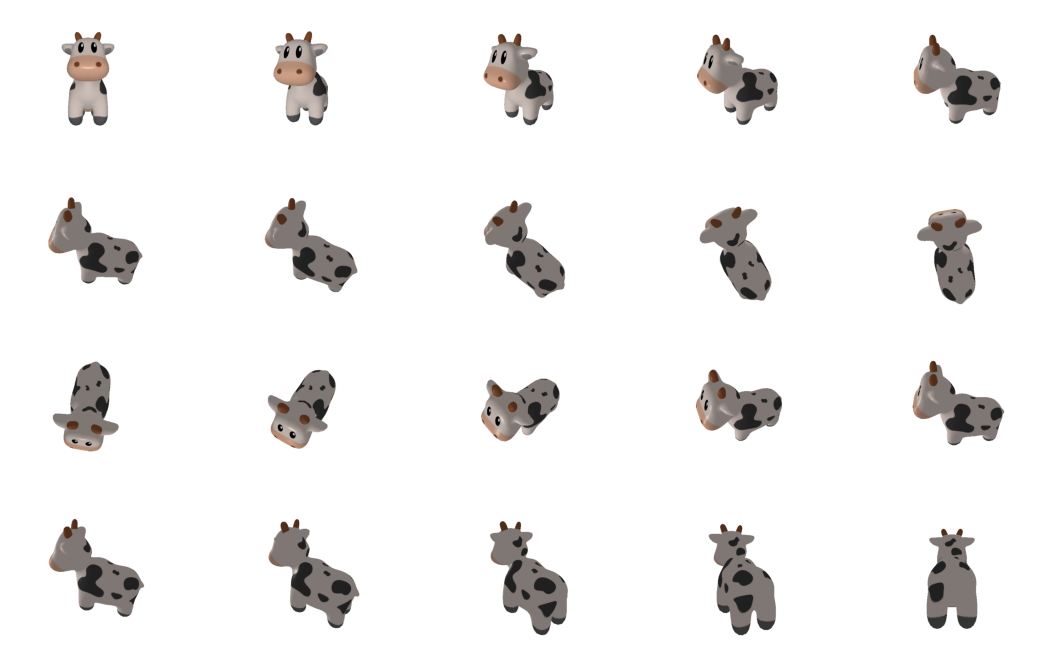

In [ ]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

# Output - Meshe and Texture
Showing diffrent type of meshe image with the help of plotly for 3d Visualization.


# meshe - 1


In [ ]:

verts, faces_idx, _ = load_obj(obj_filename)
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)],
    textures=textures
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

# Meshe - 2

Here using Plotly for diffrent colours.

In [ ]:
# use Plotly's default colors (no texture)
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)]
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

In [ ]:
# Meshe - 3

In [ ]:
# create a batch of meshes, and offset one to prevent overlap
mesh_batch = Meshes(
    verts=[verts.to(device), (verts + 2).to(device)],   
    faces=[faces.to(device), faces.to(device)]
)

# plot mesh batch in the same trace
fig = plot_scene({
    "subplot1": {
        "cow_mesh_batch": mesh_batch
    }
})
fig.show()